In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI

llm=ChatOpenAI(model='o4-mini')

In [3]:
llm.invoke("Hello, how are you?")

AIMessage(content='Hello! I’m doing well—thank you for asking. How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 12, 'total_tokens': 113, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'id': 'chatcmpl-BmcAoRceeuXmntrVUW2Y7B3gKdSve', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--2597a7d6-e093-496a-9c6a-7ebc1d0b28de-0', usage_metadata={'input_tokens': 12, 'output_tokens': 101, 'total_tokens': 113, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 64}})

In [4]:
from langchain_openai import OpenAIEmbeddings
embeddings=OpenAIEmbeddings(model='text-embedding-3-large')

In [5]:
len(embeddings.embed_query('Hi , how are you?'))

3072

In [6]:
urls=["https://lilianweng.github.io/posts/2023-06-23-agent/","https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/"]

In [7]:
from langchain_community.document_loaders import WebBaseLoader

web_text=[WebBaseLoader(url).load() for url in urls]

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
web_text

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [9]:
doc_list=[item for sub_text in web_text for item in sub_text]
doc_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_spliter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=200,chunk_overlap=20)

In [11]:
splited_text=text_spliter.split_documents(doc_list)

In [12]:
len(splited_text)

131

In [13]:
from langchain_community.vectorstores import Chroma

vectorstore=Chroma.from_documents(splited_text,embedding=embeddings,collection_name='rag-chroma')

In [14]:
retriever=vectorstore.as_retriever()

In [15]:
retriever.invoke("what is prompt engineering?")

[Document(metadata={'title': "Prompt Engineering | Lil'Log", 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.'}, page_content='Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the mode

In [16]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool=create_retriever_tool(retriever,"retriever_blog_post",
                                     "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response."
                                     )

In [17]:
tools=[retriever_tool]

In [45]:
llm_bind_tools=llm.bind_tools(tools)

In [18]:
from langgraph.prebuilt import ToolNode

retriever_node=ToolNode(tools)

In [19]:
from typing import Annotated,Sequence,TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [20]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]

In [21]:
from langchain_core.prompts import PromptTemplate

In [123]:
def llm_decision_maker(state:AgentState):
    print("----------CALL Decision Maker------")
    message=state["messages"]
    #last_message=message[-1]
    #question=last_message.content
    system_prompt=["""You are an dicision maker assistant where you will decide when the bindded tool should call.
                    If any question related to Generative AI and traditional AI related
                   then check in the tools otherwise you can give answer as per your training information."""]
    final_question=system_prompt +message
    response=llm_bind_tools.invoke(final_question)
    return {"messages":[response]}


In [124]:
from langchain.pydantic_v1 import BaseModel,Field
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score 'yes' or 'no' ")

In [125]:
from typing import Literal #we use for type hinting

In [126]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    print("----CALLING GRADE FOR CHECKING RELEVANCY----")
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
     
    chain=prompt|llm_with_structure_op
     
     
    message=state['messages']
    
    last_message = message[-1]
    
    question = message[0].content
    
    docs = last_message.content
    
    scored_result=chain.invoke({"question": question, "context": docs})
    
    score=scored_result.binary_score
     
    if score=="yes":
        print("----DECISION: DOCS ARE RELEVANT----")
        return "generator"
    else:
        print("----DECISION: DOCS ARE NOT RELEVANT----")
        return "rewriter"

In [127]:
from langchain import hub

In [128]:
prompt=hub.pull("rlm/rag-prompt")

In [129]:
prompt.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [130]:
def generate(state:AgentState):
    print("----------RAG Output Generate-------")
    message=state["messages"]
    question=message[0]
    last_message=message[-1]
    context_docs=last_message.content
    prompt=hub.pull("rlm/rag-prompt")

    rag_chain=prompt | llm

    response=rag_chain.invoke({"context": context_docs, "question": question})

    return {"messages": [response]}

In [131]:
from langchain_core.messages import HumanMessage

In [132]:
def rewrite(state:AgentState):
    print("----TRANSFORM QUERY----")
    message=state["messages"]
    
    question=message[0].content
    
    input= [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]

    response=llm.invoke(input)
    
    return {"messages": [response]}

In [133]:
from langgraph.graph import StateGraph,START,END

In [134]:
workflow=StateGraph(AgentState)

In [135]:
workflow.add_node("LLM_Decision_Maker",llm_decision_maker)

In [136]:
workflow.add_node('retriver',retriever_node)

In [137]:
workflow.add_node('Output_Generator',generate)

In [138]:
workflow.add_node("Query_Rewriter",rewrite)

In [139]:
workflow.add_edge(START,'LLM_Decision_Maker')

In [140]:
from langgraph.prebuilt import tools_condition

In [141]:
workflow.add_conditional_edges('LLM_Decision_Maker',
                               tools_condition,
                               {"tools":"retriver",
                                END:END})

In [142]:
workflow.add_conditional_edges('retriver',
                               grade_documents,
                               {"generate":"Output_Generator",
                                "rewrite":"Query_Rewriter"})

In [143]:
workflow.add_edge("Output_Generator",END)

In [144]:
workflow.add_edge("Query_Rewriter",'LLM_Decision_Maker')

In [145]:
app=workflow.compile()

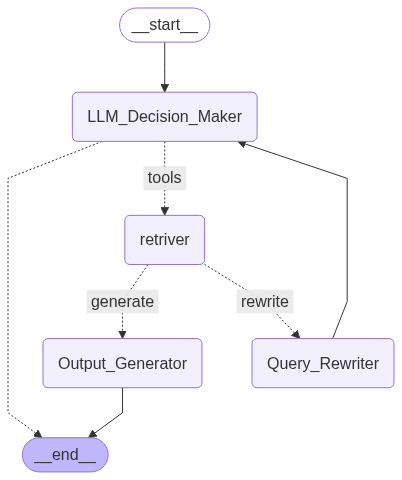

In [146]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [147]:
app.invoke({"messages":["what is agentic ai?"]})

----------CALL Decision Maker------


{'messages': [HumanMessage(content='what is agentic ai?', additional_kwargs={}, response_metadata={}, id='2b6fe04d-0c9a-4452-9356-e59409fc49e4'),
  AIMessage(content='Agentic AI refers to systems that go beyond “ask-and-respond” chat interfaces and behave more like autonomous agents: they perceive their environment, set or are given goals, plan multi‐step strategies to achieve those goals, execute actions (often by calling APIs or other tools), monitor outcomes, and adapt their plans over time.\n\nKey characteristics of agentic AI:  \n1. Goal-oriented: Rather than answering one question at a time, an agentic system pursues a higher-level objective (e.g. “research this topic, draft a report, then summarize findings”).  \n2. Planning & reasoning: It breaks its goal into a sequence of sub-tasks, deciding what to do next based on past observations or results.  \n3. Action execution: It doesn’t just generate text—it can invoke external tools (APIs, databases, scripts), browse the web, manip

In [148]:
llm_bind_tools.invoke("different types of prompting")

AIMessage(content='Here’s an overview of the most common prompting techniques used to steer large language models toward better, more reliable outputs:\n\n1. Zero-shot prompting  \n   • You give the model an instruction (or question) and expect it to answer without examples.  \n   • Pros: simple, fast.  \n   • Cons: can be brittle or under‐specified.\n\n2. One-shot prompting  \n   • You provide one worked-example plus a follow-up instruction.  \n   • Pros: shows model exactly what you want.  \n   • Cons: limited context window; careful example selection.\n\n3. Few-shot prompting  \n   • You supply several input–output examples (typically 3–10) before asking the model to generalize.  \n   • Pros: improves consistency and accuracy.  \n   • Cons: uses more tokens; diminishing returns after a point.\n\n4. Instruction-based (or “task-oriented”) prompting  \n   • You write a clear, explicit instruction (e.g. “Summarize the following text in two sentences”).  \n   • Pros: leverages models fin